# The Keras Functional API

> In this post, it will introduce the Funtional API as an alternative way of building the planning model in Tensorflow. This is the summary of lecture "Customizing your model with Tensorflow 2" from Coursera.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rcParams['figure.figsize'] = (16, 10)

print(tf.__version__)

2.3.1


## The Keras functional API

The reason you might want to use is if you need more flexibility in the type of model you want to build. For example, perhaps your model has multiple inputs and outputs because you're training and multitask learning model, or maybe you're using conditioning variables, or perhaps it has some complicated nonlinear topology with the layers feeding into multiple other layers in the network, something like a residual network or a DenseNet, for example. These are types of networks that can't be built in the simple linear fashion offered by the Sequential API. But the Functional API, makes it easy to build those types of networks. 

### Example of Sequential API
```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, AveragePooling1D

model = Sequential([
    Conv1D(16, 5, activation='relu', input_shape=(32, 1)),
    AveragePooling1D(3),
    Flatten(),
    Dense(20, activation='sigmoid')
])
```

### Example of Functional API

```python
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, AveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
outputs = Dense(20, activation='sigmoid')(h)

model = Model(inputs=inputs, outputs=outputs)
```

The difference between them is how we build the model.

## Multiple inputs and outputs

The key point is that we instantiate the layers that we want in the same way as we do for the sequential model. But we then use those layer objects as functions that call on an input tensor and return a layer output tensor.

### Multiple inputs Example

```python
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, AveragePooling1D, Concatenate

inputs = Inputs(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
aux_inputs = Input(shape=(12, 1))
h = Concatenate()([h, aux_inputs])
outputs = Dense(20, activation='sigmoid')(h)

model = Model(inputs=[inputs, aux_inputs], outputs=outputs)
```

### Multiple outputs Example

```python
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, AveragePooling1D, Concatenate

inputs = Inputs(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
aux_inputs = Input(shape=(12, 1))
h = Concatenate()([h, aux_inputs])
outputs = Dense(20, activation='sigmoid')(h)
aux_outputs = Dense(1, activation='linear')(h)

model = Model(inputs=[inputs, aux_inputs], outputs=[outputs, aux_outputs])
```

When we use multiple inputs and outputs, we need to look carefully when we compile and fit the model

```python
model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1, 0.4], metrics=['accuracy'])
history = model.fit([X_train, X_aux], [y_train, y_aux], validation_split=0.2, epochs=20)
```

In this case, loss will be

$$ 1 \times \text{binary_crossentropy loss} + 0.4 \times \text{mse loss} $$

Or we can change the compile and fit function like this,

```python
model.compile(loss={'outputs': 'binary_crossentropy', 'aux_outputs': 'mse'}, 
              loss_weights{'outputs':1, 'aux_outputs': 0.4}, metrics=['accuracy'])
history = model.fit({'inputs': X_train, 'aux_inputs': X_aux},
                    {'outputs':y_train, 'aux_outputs': y_aux},
                     validation_split=0.2, epochs=20)
```

### Multiple inputs and outputs - Coding Tutorial

#### Load the acute inflammations dataset

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

#### Load the data

In [2]:
df = pd.read_csv('./dataset/diagnosis.csv')
df.head()
dataset = df.values

In [3]:
# Build train and test data split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[:, :6], dataset[:, 6:], test_size=0.33)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80, 6) (40, 6)
(80, 2) (40, 2)


In [4]:
## Assign training and testing inputs/outputs
temp_train, nocc_train, lumbp_train, up_train, mict_train, bis_train = np.transpose(X_train)
temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test = np.transpose(X_test)

inflam_train, nephr_train = y_train[:, 0], y_train[:, 1]
inflam_test, nephr_test = y_test[:, 0], y_test[:, 1]

In [5]:
temp_train

array([41.1, 40. , 40.4, 37. , 37. , 41.5, 40.2, 36. , 37.9, 36.6, 38. ,
       37.7, 40. , 40.6, 40.5, 40.4, 40. , 36.6, 40.7, 39.4, 36.8, 37.3,
       40. , 37.6, 37.5, 37.5, 36.8, 41.4, 36.6, 37.7, 41.5, 41.5, 39.7,
       40.6, 37.3, 40.4, 37.9, 37.1, 36. , 36.3, 40. , 41.2, 38.7, 37.7,
       40.7, 41.1, 37.1, 36. , 41. , 40.7, 37.9, 38.1, 37.2, 37.5, 38.3,
       35.5, 41. , 37. , 37.8, 36.7, 40.8, 36.9, 37.4, 37. , 40.4, 38.5,
       40. , 37.5, 40.4, 41. , 37.4, 41.2, 41.2, 37.1, 40. , 36.7, 36.2,
       40.7, 37. , 36.9])

#### Build the model

In [6]:
from tensorflow.keras import Input

shape_inputs = (1, )
temperature = Input(shape=shape_inputs, name='temp')
nausea_occurence = Input(shape=shape_inputs, name='nocc')
lumbar_pain = Input(shape=shape_inputs, name='lumbp')
urine_pushing = Input(shape=shape_inputs, name='up')
micturition_pains = Input(shape=shape_inputs, name='mict')
bis = Input(shape=shape_inputs, name='bis')

list_inputs = [temperature, nausea_occurence, lumbar_pain, urine_pushing, micturition_pains, bis]

In [7]:
from tensorflow.keras.layers import concatenate

# Merge all input features into a single large vector
x = concatenate(list_inputs)

In [8]:
from tensorflow.keras.layers import Dense

# Use logistic regression classifier for disease prediction
inflammation_pred = Dense(1, activation='sigmoid', name='inflam')(x)
nephritis_pred = Dense(1, activation='sigmoid', name='nephr')(x)

In [9]:
# Create a list of all the outputs
list_outputs = [inflammation_pred, nephritis_pred]

In [10]:
from tensorflow.keras.models import Model

# Create the model object
model = Model(inputs=list_inputs, outputs=list_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
temp (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
nocc (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
lumbp (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
up (InputLayer)                 [(None, 1)]          0                                            
_______________________________________________________________________________________

#### Plot the model

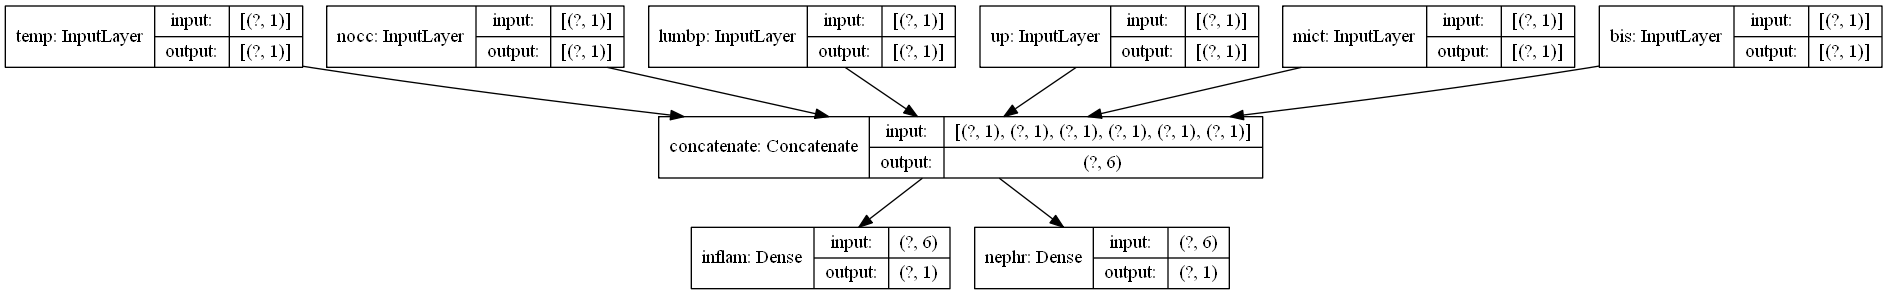

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'multi_input_output_model.png', show_shapes=True)

#### Compile the model

In [16]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
              loss={'inflam': 'binary_crossentropy', 
                    'nephr': 'binary_crossentropy'},
              metrics={
                  'inflam': ['accuracy'],
                  'nephr': ['accuracy']
              },
              loss_weights={
                  'inflam': 1.,
                  'nephr': 0.2
              })

#### Fit the model

In [17]:
# Define training inputs and ouptuts
inputs_train = {'temp': temp_train, 'nocc': nocc_train, 'lumbp': lumbp_train,
                'up': up_train, 'mict': mict_train, 'bis': bis_train}

outputs_train = {'inflam': inflam_train, 'nephr': nephr_train}

In [18]:
# Train the model
history = model.fit(inputs_train, outputs_train,
                    epochs=1000,
                    batch_size=128,
                    verbose=False)

#### Plot the learning curves

In [19]:
acc_keys = [k for k in history.history.keys() if k in ('inflam_accuracy', 'nephr_accuracy')]
loss_keys = [k for k in history.history.keys() if not k in acc_keys]

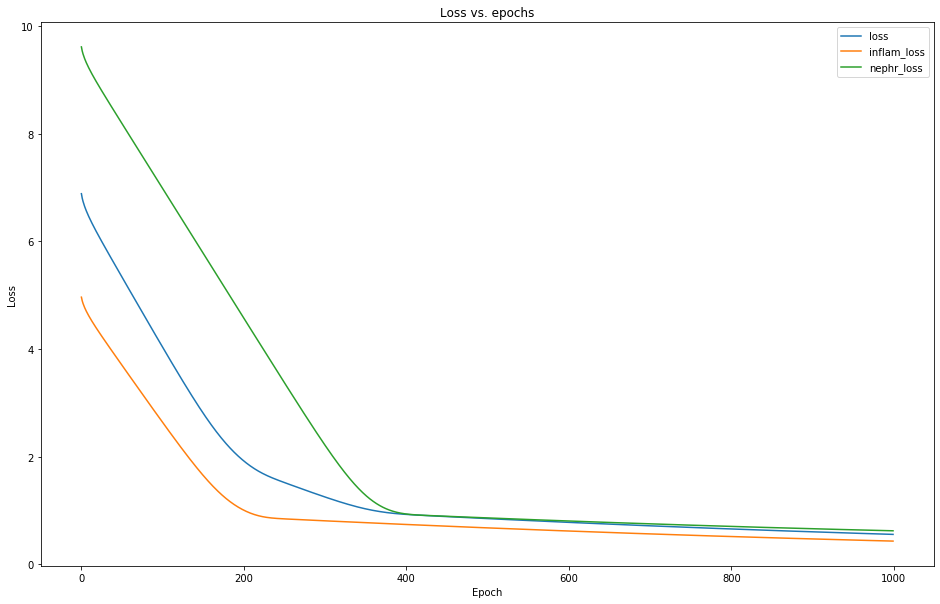

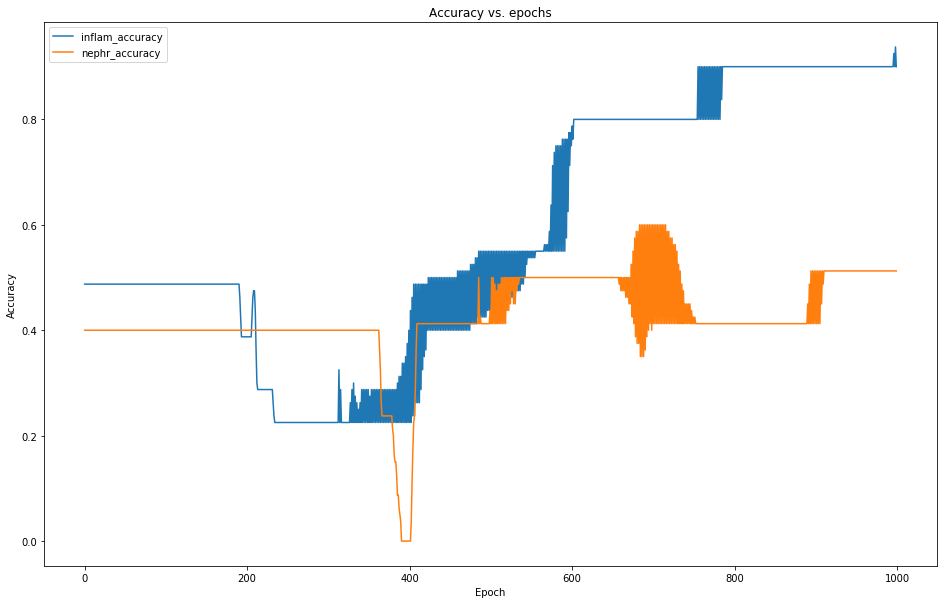

In [20]:
for k, v in history.history.items():
    if k in acc_keys:
        plt.figure(1)
        plt.plot(v)
    else:
        plt.figure(2)
        plt.plot(v)
        
plt.figure(1)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(acc_keys, loc='best')

plt.figure(2)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loss_keys, loc='best')
plt.show()

In [21]:
# Evaluate the model

model.evaluate([temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test], 
               [inflam_test, nephr_test], verbose=2)

2/2 - 0s - loss: 0.5562 - inflam_loss: 0.4258 - nephr_loss: 0.6520 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.4500


[0.5562416315078735,
 0.42584753036499023,
 0.651970386505127,
 1.0,
 0.44999998807907104]

## Variables

An important point about tensorflow variablesis that they persist throughout your program, but they contain values that can be changed over the course of your program. Usually, we'll be using
variables as part of our models, and when we call `model.fit` to launch the training run, this will change the variable values for us as part of the optimization, but we can also change the variable values manually. Every variable has an assigned method, and we can just pass this method a new value for the
variable to store. Notice that the new value on assigning needs to be the right shape for the variable.

```python
import tensorflow as tf

my_var = tf.Variable([-1, 2], dtype=tf.float32, name='my_var')
my_var.assign([3.5, -1.])
```

## Tensors

Tensors - Multidimensional versions of vectors and arrays

When we build that neural network models, what we're doing is defining a computational graph
where input data is processed through the layers of the network and sent through the graph
all the way to the outputs. Tensors of the object that gets passed around within the graph and capture those computations within the graph.

### Example 1

In [22]:
# Example
# Simple computation graph
my_var = tf.Variable([-1, 2], dtype=tf.float32, name='my_var')
h = my_var + [5, 4]

print(h)

tf.Tensor([4. 6.], shape=(2,), dtype=float32)


### Example 2

In [23]:
from tensorflow.keras.layers import Dense, Input

inputs = Input(shape=(5, ))
h = Dense(16, activation='relu')(inputs)

print(h)

Tensor("dense/Relu:0", shape=(None, 16), dtype=float32)


In [24]:
inputs = Input(shape=(5, ))
h = Dense(16, activation='sigmoid')(inputs)
outputs = Dense(10, activation='softmax')(h)

model = Model(inputs=inputs, outputs=outputs)

print(model.input)
print(model.output)

Tensor("input_2:0", shape=(None, 5), dtype=float32)
Tensor("dense_2/Softmax:0", shape=(None, 10), dtype=float32)


## Variables and Tensors - Coding Tutorial

### Create variable objects

In [25]:
strings = tf.Variable(['Hello world!'], dtype=tf.string)
floats = tf.Variable([3.14159, 2.71828], dtype=tf.float32)
ints = tf.Variable([1, 2, 3], dtype=tf.int32)
complexs = tf.Variable([25.9 - 7.39j, 1.23 - 4.91j], tf.complex128)

In [26]:
# Initialize a Variable value
tf.Variable(tf.constant(4.2, shape=(3, 3)))

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2]], dtype=float32)>

### Use and modify variable values

In [27]:
v = tf.Variable(0.0)
w = v + 1

print(type(w))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [28]:
# Increment the value of a variable
v.assign_add(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [29]:
# Decrement the value of a variable
v.assign_sub(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>


### Create Tensor objects

Create a constant tensor and print its type as well as its shape

In [30]:
x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(x)
print('dtype: ', x.dtype)
print('shape: ', x.shape)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)
dtype:  <dtype: 'int32'>
shape:  (3, 3)


In [31]:
# Obtain the value as a numpy array
x.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [32]:
# Create a tensor of type float32
x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=tf.float32)
print(x.dtype)

<dtype: 'float32'>


In [33]:
# Create coefficients
coeffs = np.arange(16)

In [34]:
# Initialize shapes
shape1 = [8, 2]
shape2 = [4, 4]
shape3 = [2, 2, 2, 2]

In [35]:
# Create tensors of different shape
a = tf.constant(coeffs, shape=shape1)
print('\n a:\n ', a)

b = tf.constant(coeffs, shape=shape2)
print('\n b:\n ', b)

c = tf.constant(coeffs, shape=shape3)
print('\n c:\n ', c)


 a:
  tf.Tensor(
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]], shape=(8, 2), dtype=int32)

 b:
  tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]], shape=(4, 4), dtype=int32)

 c:
  tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]], shape=(2, 2, 2, 2), dtype=int32)


### Useful Tensor operations

In [36]:
# Create a constant tensor
t = tf.constant(np.arange(80), shape=[5, 2, 8])

In [37]:
# Get the rank of a Tensor
rank = tf.rank(t)

In [38]:
# Display the rank
print('rank :', rank)

rank : tf.Tensor(3, shape=(), dtype=int32)


In [39]:
# Reshape a Tensor
t2 = tf.reshape(t, [8, 10])

In [40]:
# Display the new shape
print('t2.shape: ', t2.shape)

t2.shape:  (8, 10)


In [41]:
# Create ones, zeros, identity and constant tensors
ones = tf.ones(shape=(2, 3))
zeros = tf.zeros(shape=(2, 4))
eye = tf.eye(3)
tensor7 = tf.constant(7.0, shape=[2, 2])

In [42]:
print("\n Ones:\n", ones)
print("\n Zeros:\n", zeros)
print("\n Identity:\n", eye)
print("\n Tensor filled with 7: ", tensor7)


 Ones:
 tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)

 Zeros:
 tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)

 Identity:
 tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

 Tensor filled with 7:  tf.Tensor(
[[7. 7.]
 [7. 7.]], shape=(2, 2), dtype=float32)


In [43]:
# Create a ones tensor and a zeros tensor
t1 = tf.ones(shape=(2, 2))
t2 = tf.zeros(shape=(2, 2))

In [44]:
# Concatenate two tensors
concat0 = tf.concat([t1, t2], 0)
concat1 = tf.concat([t1, t2], 1)

In [45]:
print(concat0)
print(concat1)

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]], shape=(2, 4), dtype=float32)


In [46]:
# Create a constant tensor
t = tf.constant(np.arange(24), shape=(3, 2, 4))
print("\n t shape: ", t.shape)


 t shape:  (3, 2, 4)


In [47]:
# Expanding the rank of tensors
t1 = tf.expand_dims(t, 0)
t2 = tf.expand_dims(t, 1)
t3 = tf.expand_dims(t, 3)

In [48]:
# Display the shapes after tf.expand_dims
print("\n After expanding dims: \n t1 shape: ", t1.shape, 
      "\n t2 shape: ", t2.shape, 
      "\n t3 shape: ", t3.shape)


 After expanding dims: 
 t1 shape:  (1, 3, 2, 4) 
 t2 shape:  (3, 1, 2, 4) 
 t3 shape:  (3, 2, 4, 1)


In [49]:
# Squeezing redundant dimensions
t1 = tf.squeeze(t1, 0)
t2 = tf.squeeze(t2, 1)
t3 = tf.squeeze(t3, 3)

print("\n After Squeezing:\n t1 shape: ", t1.shape,
      "\n t2 shape: ", t2.shape,
      "\n t3 shape: ", t3.shape)


 After Squeezing:
 t1 shape:  (3, 2, 4) 
 t2 shape:  (3, 2, 4) 
 t3 shape:  (3, 2, 4)


In [50]:
# Slicing a tensor
x = tf.constant([1, 2, 3, 4, 5, 6, 7])
print(x[1:4])

tf.Tensor([2 3 4], shape=(3,), dtype=int32)


### Doing maths with Tensors

In [51]:
# Create two constant Tensors
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])

In [52]:
# Matrix multiplication
matmul_cd = tf.matmul(c, d)

# Display the result
print("tf.matmul(c, d): \n", matmul_cd)

tf.matmul(c, d): 
 tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [53]:
# Elementwise operations
c_times_d = c * d
c_plus_d = c + d
c_minus_d = c - d
c_div_c = c / c

print("c * d: \n", c_times_d)
print("c + d: \n", c_plus_d)
print("c - d: \n", c_minus_d)
print("c / c: \n", c_div_c)

c * d: 
 tf.Tensor(
[[1. 2.]
 [0. 4.]], shape=(2, 2), dtype=float32)
c + d: 
 tf.Tensor(
[[2. 3.]
 [3. 5.]], shape=(2, 2), dtype=float32)
c - d: 
 tf.Tensor(
[[0. 1.]
 [3. 3.]], shape=(2, 2), dtype=float32)
c / c: 
 tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


In [54]:
# Create tensors
a = tf.constant([[2, 3], [3, 3]])
b = tf.constant([[8, 7], [2, 3]])
x = tf.constant([[-6.89 + 1.78j], [-2.54 + 2.15j]])

In [55]:
# Absolute value of a Tensor
absx = tf.abs(x)

In [56]:
# Power of a tensor
powaa = tf.pow(a, a)

In [57]:
# Display the result
print(absx)
print(powaa)

tf.Tensor(
[[7.11621388]
 [3.32777704]], shape=(2, 1), dtype=float64)
tf.Tensor(
[[ 4 27]
 [27 27]], shape=(2, 2), dtype=int32)


### Randomly sampled constant tensors

In [58]:
# Normal distribution
tn = tf.random.normal(shape=(2, 2), mean=0, stddev=1.)

In [60]:
# Uniform distribution
tu = tf.random.uniform(shape=(2, 1), minval=0, maxval=10, dtype='int32')

In [61]:
# Poisson Distribution
tp = tf.random.poisson(shape=(2, 2), lam=5)

In [62]:
# More math operations
d = tf.square(tn)
e = tf.exp(d)
f = tf.cos(c)

## Accessing Layer Variables

How the extract the model weights


In [64]:
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Flatten

inputs = Input(shape=(32, 1))
h = Conv1D(16, 5, activation='relu')(inputs)
h = AveragePooling1D(3)(h)
h = Flatten()(h)
outputs = Dense(20, activation='sigmoid')(h)

model = Model(inputs=inputs, outputs=outputs)

In [66]:
from pprint import pprint

pprint(model.layers)

In [69]:
model.layers[1].weights

[<tf.Variable 'conv1d_1/kernel:0' shape=(5, 1, 16) dtype=float32, numpy=
 array([[[-1.91693217e-01, -1.38678432e-01,  6.96650147e-02,
           2.38906115e-01, -2.19139457e-03, -2.37000912e-01,
          -2.01916754e-01, -6.29762113e-02, -1.95426852e-01,
          -9.19391662e-02, -5.50110042e-02, -3.96974981e-02,
           1.06680483e-01, -2.34250769e-01, -1.78139225e-01,
           2.92662382e-02]],
 
        [[ 5.74857295e-02,  1.15011036e-01, -2.09682882e-02,
           2.20392644e-01, -2.50446320e-01, -8.92207026e-03,
           9.52592790e-02, -2.41798222e-01, -1.97773546e-01,
           9.81920362e-02,  1.03087276e-01, -5.37133366e-02,
          -1.21887684e-01,  1.65095657e-01,  1.95207417e-01,
           2.48339027e-01]],
 
        [[-3.58236879e-02,  5.02088368e-02,  1.77805781e-01,
          -2.23398656e-01, -1.79458678e-01,  8.69320035e-02,
           1.48380339e-01,  1.18708521e-01,  8.33250582e-02,
           2.23368198e-01,  2.18457609e-01,  2.64346600e-04,
          -

In [71]:
# kernel
model.layers[1].kernel

<tf.Variable 'conv1d_1/kernel:0' shape=(5, 1, 16) dtype=float32, numpy=
array([[[-1.91693217e-01, -1.38678432e-01,  6.96650147e-02,
          2.38906115e-01, -2.19139457e-03, -2.37000912e-01,
         -2.01916754e-01, -6.29762113e-02, -1.95426852e-01,
         -9.19391662e-02, -5.50110042e-02, -3.96974981e-02,
          1.06680483e-01, -2.34250769e-01, -1.78139225e-01,
          2.92662382e-02]],

       [[ 5.74857295e-02,  1.15011036e-01, -2.09682882e-02,
          2.20392644e-01, -2.50446320e-01, -8.92207026e-03,
          9.52592790e-02, -2.41798222e-01, -1.97773546e-01,
          9.81920362e-02,  1.03087276e-01, -5.37133366e-02,
         -1.21887684e-01,  1.65095657e-01,  1.95207417e-01,
          2.48339027e-01]],

       [[-3.58236879e-02,  5.02088368e-02,  1.77805781e-01,
         -2.23398656e-01, -1.79458678e-01,  8.69320035e-02,
          1.48380339e-01,  1.18708521e-01,  8.33250582e-02,
          2.23368198e-01,  2.18457609e-01,  2.64346600e-04,
         -1.40938610e-01, -2.3

In [72]:
model.layers[1].bias

<tf.Variable 'conv1d_1/bias:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

Or we can access each layer by using defined name of layer

In [73]:
inputs = Input(shape=(32, 1), name='input_layer')
h = Conv1D(16, 5, activation='relu', name='conv1d_layer')(inputs)
h = AveragePooling1D(3, name='avg_pool1d_layer')(h)
h = Flatten(name='flatten_layer')(h)
outputs = Dense(20, activation='sigmoid', name='dense_layer')(h)

model = Model(inputs=inputs, outputs=outputs)

In [75]:
model.get_layer('conv1d_layer').weights

[<tf.Variable 'conv1d_layer/kernel:0' shape=(5, 1, 16) dtype=float32, numpy=
 array([[[ 0.15915683, -0.05852906,  0.00935325, -0.15417323,
           0.10186544,  0.10887289, -0.22774723,  0.11048397,
           0.08124369, -0.07884574,  0.22654533, -0.1266062 ,
           0.211887  , -0.10518676, -0.03523357,  0.0067037 ]],
 
        [[ 0.13217229, -0.2539651 , -0.17479959, -0.04364847,
          -0.18451145,  0.08652538,  0.16114056, -0.08005409,
           0.09219551, -0.09325977, -0.21805988,  0.09489688,
          -0.00092167, -0.21019907,  0.04875761,  0.25174144]],
 
        [[ 0.01395541, -0.02523801,  0.1916312 ,  0.03920323,
           0.03210104,  0.26281413, -0.08946513,  0.20994988,
          -0.12481894,  0.14540899,  0.05179927,  0.05328849,
           0.05503711,  0.10141227, -0.21076518, -0.13703719]],
 
        [[ 0.2649139 ,  0.19635484, -0.10279508,  0.21558231,
           0.13189575, -0.23905839,  0.20185792, -0.17609581,
           0.07652375,  0.25605866, -0.2265

## Accessing Layer Tensors

In [76]:
model.get_layer('conv1d_layer').input

<tf.Tensor 'input_layer:0' shape=(None, 32, 1) dtype=float32>

In [77]:
model.get_layer('conv1d_layer').output

<tf.Tensor 'conv1d_layer/Relu:0' shape=(None, 28, 16) dtype=float32>

## Accessing model layers - Coding tutorial

### Load the pre-trained model
In this section, we aim to demonstrate accessing layer attributes within a model.

Let's get started by loading the `VGG19` pre-trained model from the `keras.applications` library, which is a very deep network trained on more than a million images from the ImageNet database. The network is trained to classify images into 1000 object categories.


In [79]:
# Load the VGG19 model
from tensorflow.keras.applications import VGG19

vgg_model = VGG19(weights='imagenet')

574717952/574710816 [==============================] - 45s 0us/step


In [80]:
# Get the inputs, layers and display the summary
vgg_input = vgg_model.input
vgg_layers = vgg_model.layers
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Build a model to access the layer outputs


In [82]:
# Build a model that returns the layer outputs
layer_outputs = [layer.output for layer in vgg_layers]
features = Model(inputs=vgg_input, outputs=layer_outputs)

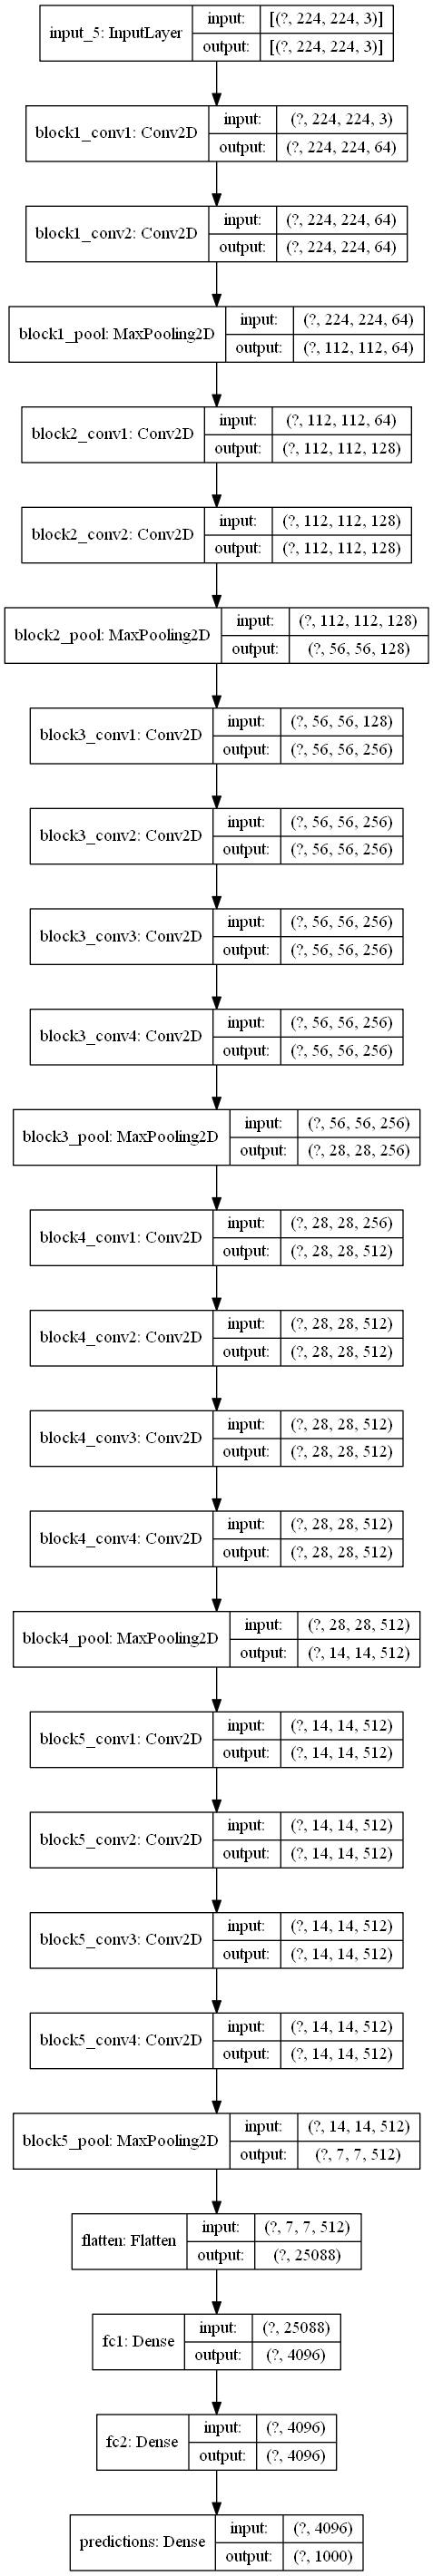

In [83]:
# Plot the model
plot_model(features, 'vgg19_model.png', show_shapes=True)

In [84]:
# Test the model on a random input
img = np.random.random((1, 224, 224, 3)).astype('float32')
extracted_features = features(img)

### Load the cool cat picture

In Zambia’s South Luangwa National Park, a photographer had been watching a pride of lions while they slept off a feast from a buffalo kill. When this female walked away, he anticipated that she might be going for a drink and so he positioned his vehicle on the opposite side of the waterhole. The `cool cat` picture is one of the highly commended 2018 Image from Wildlife Photographer of the Year.

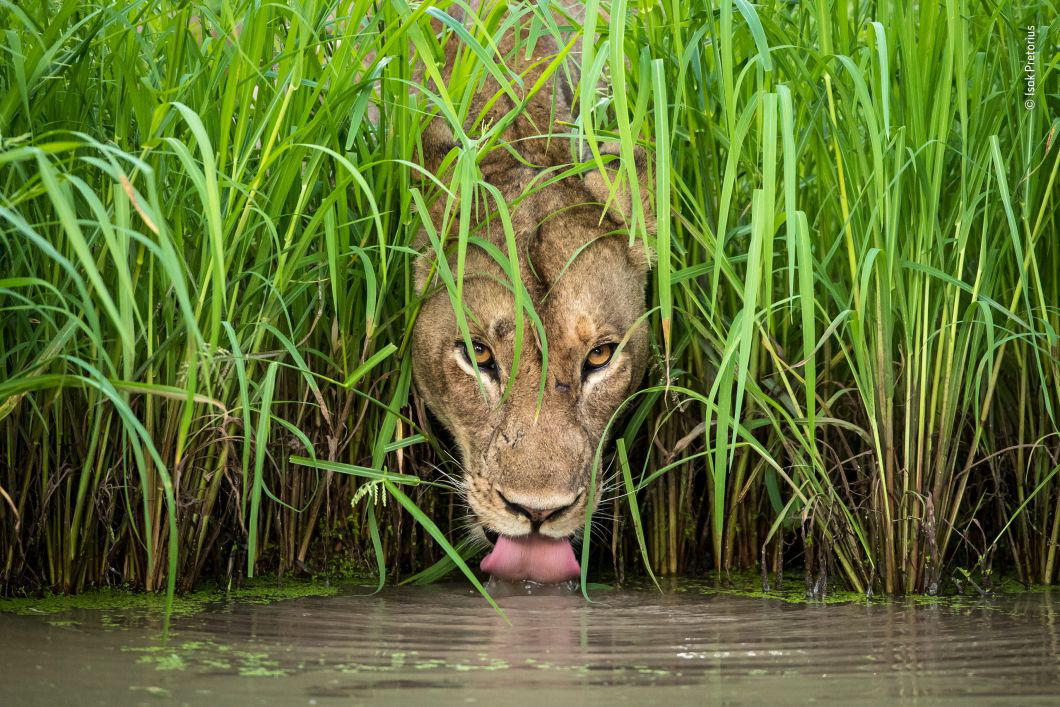

In [85]:
import IPython.display as display
from PIL import Image

display.display(Image.open('dataset/cool_cat.jpg'))

### Visualize network features from the input image

In [86]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

img = image.load_img('./dataset/cool_cat.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = tf.expand_dims(x, axis=0)
x = preprocess_input(x)

In [87]:
# Extract the features
extracted_features = features(x)

f1.shape:  (1, 224, 224, 3)


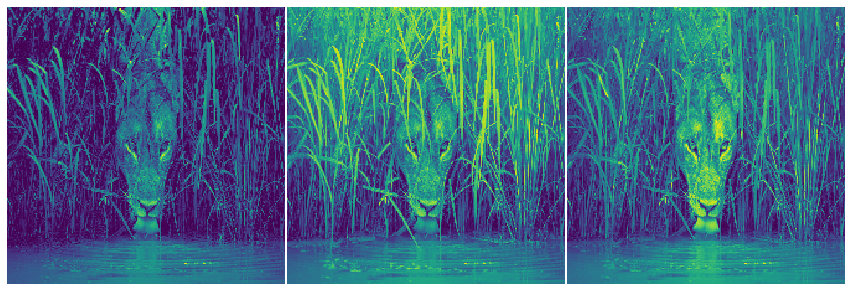

In [88]:
# Visualize the input channels
f1 = extracted_features[0]
print('f1.shape: ', f1.shape)

imgs = f1[0, :, :]
plt.figure(figsize=(15, 15))

for n in range(3):
    ax = plt.subplot(1, 3, n + 1)
    plt.imshow(imgs[:, :, n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

f2.shape:  (1, 224, 224, 64)


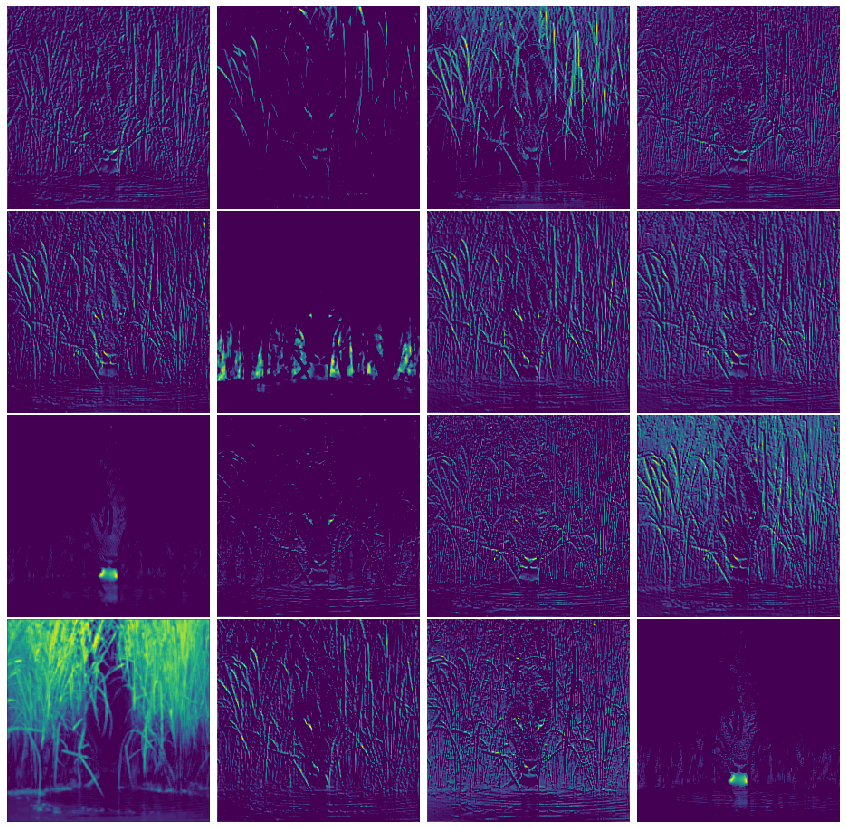

In [89]:
# Visualize some features in the first hidden layer
f2 = extracted_features[1]
print('f2.shape: ', f2.shape)

imgs = f2[0, :, :]
plt.figure(figsize=(15, 15))

for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(imgs[:, :, n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

In [90]:
# Build a model to extract features by layer name
extracted_features_block1_pool = Model(inputs=features.input, 
                                       outputs=features.get_layer('block1_pool').output)
block1_pool_features = extracted_features_block1_pool.predict(x)

f3.shape:  (1, 112, 112, 64)


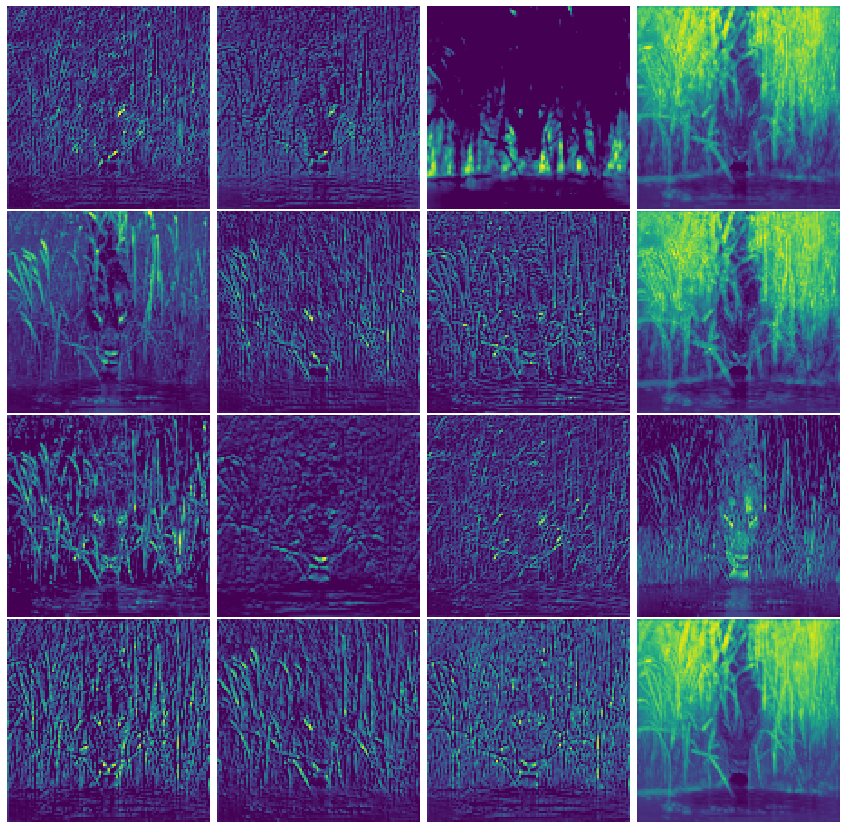

In [92]:
# Visualize some features in the first hidden layer
f3 = block1_pool_features
print('f3.shape: ', f3.shape)

imgs = f3[0, :, :]
plt.figure(figsize=(15, 15))

for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(imgs[:, :, n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

f4.shape:  (1, 14, 14, 512)


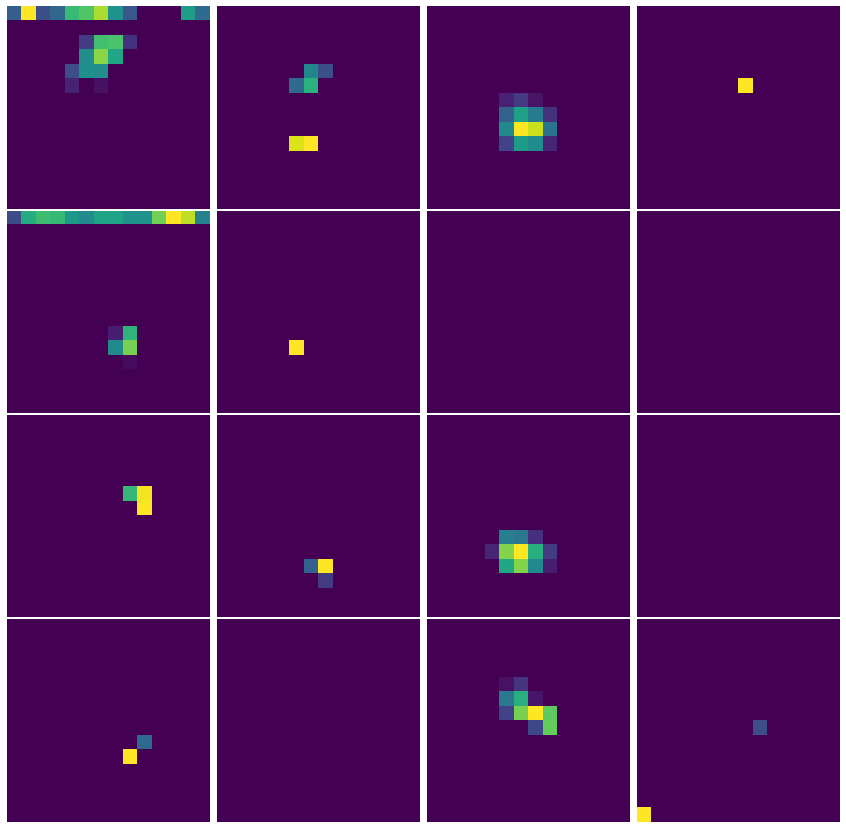

In [93]:
# Build a model to extract features by layer name
extracted_features_block5_conv4 = Model(inputs=features.input, 
                                       outputs=features.get_layer('block5_conv4').output)
block5_conv4_features = extracted_features_block5_conv4.predict(x)

# Visualize some features in the first hidden layer
f4 = block5_conv4_features
print('f4.shape: ', f4.shape)

imgs = f4[0, :, :]
plt.figure(figsize=(15, 15))

for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(imgs[:, :, n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

## Layer nodes

### Creating a simple computational graph
You have previously seen how to construct multiple input or output models, and also how to access model layers. Let's start by creating two inputs:


In [94]:
a = Input(shape=(128, 128, 3), name='input_a')
b = Input(shape=(64, 64, 3), name='input_b')

Now, we create a 2D convolutional layer, and call it on one of the inputs

In [95]:
from tensorflow.keras.layers import Conv2D
conv = Conv2D(32, (6, 6), padding='SAME')
conv_out_a = conv(a)
print(type(conv_out_a))

<class 'tensorflow.python.framework.ops.Tensor'>


The output of the layer is now a new Tensor, which captures the operation of calling the layer `conv` on the input `a`.

By defining this new operation in our computational graph, we have added a _node_ to the `conv` layer. This node relates the input tensor to the output tensor.

### Layer input and outputs
We can retrieve the output of a layer using the `output` attribute, and we can also get the input by using the `input` attribute. 

Similarly, we can retrieve the input/output shape using `input_shape` and `output_shape`.

In [96]:
# Print the input and output tensors
print(conv.input)
print(conv.output)

Tensor("input_a:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("conv2d/BiasAdd:0", shape=(None, 128, 128, 32), dtype=float32)


In [98]:
# Verify the input and output shape
assert conv.input_shape == (None,  128, 128, 3)
assert conv.output_shape == (None, 128, 128, 32)

### Creating a new layer node

Now, let's call this layer again on a different input:

In [99]:
conv_out_b = conv(b)

When we call the same layer multiple times, that layer owns multiple nodes indexed as 0, 1, 2...

Now, what happens if we call `input` and `output` for this layer?

In [100]:
assert conv.input.name == a.name
assert conv.output.name == conv_out_a.name

As you can see, the layer's input is identified as being `a` and its output as being `conved_a`, something is going wrong here. As long as a layer is only connected to one input, there is no confusion about what should be the input, and `.output` will return the one output of the layer, but when the layer is called on multiple inputs we end up in an ambiguous situation.

Let's try to get the input/output shape:

In [101]:
conv.input_shape

AttributeError: The layer "conv2d has multiple inbound nodes, with different input shapes. Hence the notion of "input shape" is ill-defined for the layer. Use `get_input_shape_at(node_index)` instead.

In [102]:
conv.output_shape

AttributeError: The layer "conv2d" has multiple inbound nodes, with different output shapes. Hence the notion of "output shape" is ill-defined for the layer. Use `get_output_shape_at(node_index)` instead.

`input_shape` and `output_shape` did not return the shape of the two inputs and outputs, instead they returned an error.

### Indexing layer nodes

We have applied the same Conv2D layer to an input of shape (128, 128, 3), and then to an input of shape (64, 64, 3), therefore the layer has multiple input/output shapes, for this reason we now have to retrieve them by specifying the index of the node they belong to.

To get the inputs/outputs shapes, we now have to use `get_input_shape_at` and `get_output_shape_at` with the correct index:

In [103]:
assert conv.get_input_shape_at(0) == (None, 128, 128, 3)  # Tensor a
assert conv.get_input_shape_at(1) == (None, 64, 64, 3)  # Tensor b

assert conv.get_output_shape_at(0) == (None, 128, 128, 32)  # Tensor conv_out_a
assert conv.get_output_shape_at(1) == (None, 64, 64, 32)  # Tensor conv_out_b

Likewise, we use `get_input_at` and `get_output_at` to fetch the inputs/outputs:

In [104]:
assert conv.get_input_at(0).name == a.name
assert conv.get_input_at(1).name == b.name

assert conv.get_output_at(0).name == conv_out_a.name
assert conv.get_output_at(1).name == conv_out_b.name

### Further reading and resources 
* https://keras.io/getting-started/functional-api-guide/#the-concept-of-layer-node

## Freezing layers

It is a very typical thing to do in transfer learning, where we take part of a pre-trained model and essentially use it as a feature extractor for a new model that we'd like to train on a separate dataset. While we do this though, we might want to make sure that the parameters of the model component we're using stay fixed during the training, and there we only train the new layers we've added to the model.

In [105]:
from tensorflow.keras.layers import MaxPooling2D

inputs = Input(shape=(8, 8, 1), name='input_layer')
h = Conv2D(16, 3, activation='relu', name='conv2d_layer')(inputs)
h = MaxPooling2D(3, name='max_pool2d_layer')(h)
h = Flatten(name='flatten_layer')(h)
outputs = Dense(10, activation='softmax', name='softmax_layer')(h)

model = Model(inputs=inputs, outputs=outputs)

If we want to freeze conv layer,

In [106]:
inputs = Input(shape=(8, 8, 1), name='input_layer')
h = Conv2D(16, 3, activation='relu', name='conv2d_layer', trainable=False)(inputs)
h = MaxPooling2D(3, name='max_pool2d_layer')(h)
h = Flatten(name='flatten_layer')(h)
outputs = Dense(10, activation='softmax', name='softmax_layer')(h)

model = Model(inputs=inputs, outputs=outputs)

Or we can apply it with get_layer in same manner.

In [107]:
model.get_layer('conv2d_layer').trainable = False

## Freezing layers - Coding tutorial

### Build the model

In [108]:
from tensorflow.keras.models import Sequential

model = Sequential([
    Dense(4, input_shape=(4, ), activation='relu', kernel_initializer='random_uniform', 
          bias_initializer='ones'),
    Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    Dense(4, activation='softmax')
])

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


### Examine the weight matrix variation over training

In [125]:
def  get_weights(model):
    return [e.weights[0].numpy() for e in model.layers]

def get_biases(model):
    return [e.bias.numpy() for e in model.layers]

def plot_delta_weights(W0_lyaers, W1_layers, b0_layers, b1_layers):
    # Plot the variation
    plt.figure(figsize=(8, 8))
    
    for n in range(3):
        delta_l = W1_layers[n] - W0_layers[n]
        print("Layer " + str(n) + ': Bias variation: ', np.linalg.norm(b1_layers[n] - b0_layers[n]))
        ax = plt.subplot(1, 3, n + 1)
        plt.imshow(delta_l)
        plt.title('Layer ' + str(n))
        plt.axis('off')
    plt.colorbar()
    plt.suptitle('Weight matrices variation')
    plt.show()

In [119]:
# Retrieve the weights and biases
W0_layers = get_weights(model)
b0_layers = get_biases(model)

In [120]:
# Construct a synthetic dataset
X_train = np.random.random((100, 4))
y_train = X_train

X_test = np.random.random((20, 4))
y = X_test

In [121]:
# Compile and fit the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, verbose=False)

In [123]:
# Retrieve weights and biases
W1_layers = get_weights(model)
b1_layers = get_biases(model)

Layer 0: Bias variation:  0.009532692
Layer 1: Bias variation:  0.012828657
Layer 2: Bias variation:  0.1793892


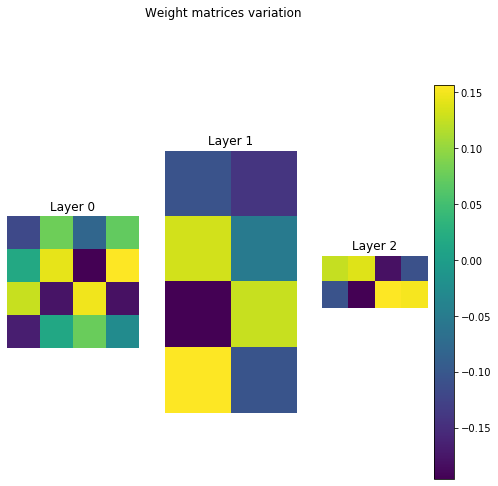

In [126]:
plot_delta_weights(W0_layers, W1_layers, b0_layers, b1_layers)

### Freeze layers at build time

In [127]:
# Count the trainable and non-trainable variables before freezing
n_trainable_variables = len(model.trainable_variables)
n_non_trainable_variables = len(model.non_trainable_variables)

In [128]:
# Display the number of trainable and non-trainable variables before freezing
print("Before freezing: \n\t Number of trainable variables: ", n_trainable_variables,
      "\n\t Number of non Trainable variables: ", n_non_trainable_variables)

Before freezing: 
	 Number of trainable variables:  6 
	 Number of non Trainable variables:  0


In [129]:
# Build the model
model = Sequential([
    Dense(4, input_shape=(4, ), activation='relu', kernel_initializer='random_uniform', 
          bias_initializer='ones', trainable=False),
    Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    Dense(4, activation='softmax')
])

In [131]:
# Count the trainable and non-trainable variables before freezing
n_trainable_variables = len(model.trainable_variables)
n_non_trainable_variables = len(model.non_trainable_variables)

# Display the number of trainable and non-trainable variables before freezing
print("Before freezing: \n\t Number of trainable variables: ", n_trainable_variables,
      "\n\t Number of non Trainable variables: ", n_non_trainable_variables)

Before freezing: 
	 Number of trainable variables:  4 
	 Number of non Trainable variables:  2


In [132]:
W0_layers = get_weights(model)
b0_layers = get_biases(model)

In [133]:
model.compile(optimizer='adam',
              loss='mse', 
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, verbose=False);

In [134]:
W1_layers = get_weights(model)
b1_layers = get_biases(model)

Layer 0: Bias variation:  0.0
Layer 1: Bias variation:  0.06926358
Layer 2: Bias variation:  0.11425926


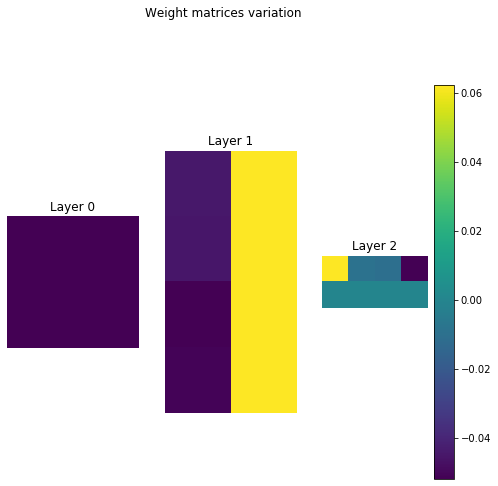

In [135]:
plot_delta_weights(W0_layers, W1_layers, b0_layers, b1_layers)

### Freeze layers of pre-built model



In [137]:
# Display the number of trainable and non-trainable variables before freezing
print("Before freezing: \n\t Number of trainable variables: ", len(model.trainable_variables),
      "\n\t Number of non Trainable variables: ", len(model.non_trainable_variables))

Before freezing: 
	 Number of trainable variables:  4 
	 Number of non Trainable variables:  2


In [138]:
# Freeze the second layer
model.layers[1].trainable=False

In [139]:
# Display the number of trainable and non-trainable variables before freezing
print("After freezing: \n\t Number of trainable variables: ", len(model.trainable_variables),
      "\n\t Number of non Trainable variables: ", len(model.non_trainable_variables))

After freezing: 
	 Number of trainable variables:  2 
	 Number of non Trainable variables:  4


In [144]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy']);

model.fit(X_train, y_train, epochs=50, verbose=False);

In [145]:
W2_layers = get_weights(model)
b2_layers = get_biases(model)

Layer 0: Bias variation:  0.0
Layer 1: Bias variation:  0.0
Layer 2: Bias variation:  0.04142955


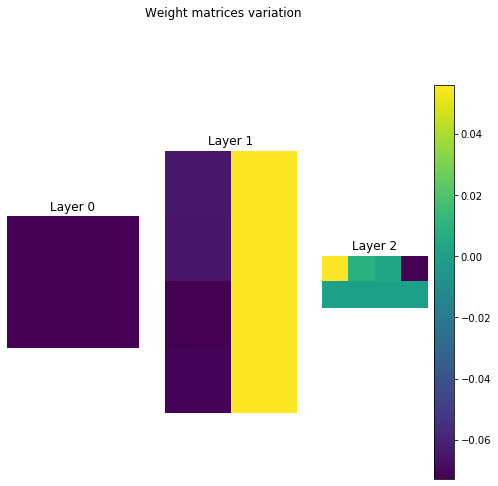

In [146]:
plot_delta_weights(W1_layers, W2_layers, b1_layers, b2_layers)

## Device Placement

In this reading, we are going to be looking at device placement. We will see how to access the device associated to a given tensor, and compare the use of GPUs and CPUs.

### Get the physical devices
First, we can list the physical devices available.

In [148]:
# List all physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

If you have enabled the GPU runtime, then you should see the GPU device in the above list.

We can also check specifically for the GPU or CPU devices.

In [149]:
# Check for GPU devices
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [150]:
# Check for CPU devices
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

We can get the GPU device name as follows:

In [151]:
# Get the GPU device name
tf.test.gpu_device_name()

'/device:GPU:0'

### Placement of Tensor operations

TensorFlow will automatically allocate Tensor operations to a physical device, and will handle the copying between CPU and GPU memory if necessary.

Let's define a random Tensor:

In [152]:
# Define a Tensor
x = tf.random.uniform([3, 3])

We can see which device this Tensor is placed on using its `device` attribute.

In [153]:
# Get the Tensor device
x.device

'/job:localhost/replica:0/task:0/device:GPU:0'

The above string will end with `'GPU:K'` if the Tensor is placed on the `K`-th GPU device. We can also check if a tensor is placed on a specific device by using `device_endswith`:

In [154]:
print("Is the Tensor on CPU #0:  "),
print(x.device.endswith('CPU:0'))
print('')
print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is the Tensor on CPU #0:  
False

Is the Tensor on GPU #0:  
True


### Specifying device placement

As mentioned previously, TensorFlow will automatically allocate Tensor operations to specific devices. However, it is possible to force placement on specific devices, if they are available. 

We can view the benefits of GPU acceleration by running some tests and placing the operations on the CPU or GPU respectively.

In [155]:
# Define simple tests to time computation speed
import time

def time_matadd(x):
    start = time.time()
    for loop in range(10):
        tf.add(x, x)
    result = time.time()-start
    print("Matrix addition (10 loops): {:0.2f}ms".format(1000*result))


def time_matmul(x):
    start = time.time()
    for loop in range(10):
        tf.matmul(x, x)
    result = time.time()-start
    print("Matrix multiplication (10 loops): {:0.2f}ms".format(1000*result))

In the following cell, we run the above tests inside the context `with tf.device("CPU:0")`, which forces the operations to be run on the CPU.

In [156]:
# Force execution on CPU

print("On CPU:")
with tf.device("CPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matadd(x)
    time_matmul(x)

On CPU:
Matrix addition (10 loops): 12.00ms
Matrix multiplication (10 loops): 74.00ms


And now run the same operations on the GPU:

In [157]:
# Force execution on GPU #0 if available

if tf.config.experimental.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("GPU:0"): 
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matadd(x)
        time_matmul(x)

On GPU:
Matrix addition (10 loops): 1.00ms
Matrix multiplication (10 loops): 14.00ms


Note the significant time difference between running these operations on different devices.

### Model training

Finally, we will demonstrate that GPU device placement offers speedup benefits for model training.



In [159]:
from tensorflow.keras.datasets import mnist
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train/255., X_test/255.

In [160]:
# Reduce the dataset size to speed up the test
X_train, y_train = X_train[:1000], y_train[:1000]

In [161]:
from tensorflow.keras import layers
from tensorflow.keras.models import  Sequential

def get_model():
  model = Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(10, activation='softmax'),
      ])
  return model

In [163]:
# Time a training run on the CPU

with tf.device("CPU:0"):
  model = get_model()
  model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  start = time.time()
  model.fit(X_train[..., np.newaxis], y_train, epochs=5, verbose=0)
  result = time.time() - start

print("CPU training time: {:0.2f}ms".format(1000 * result))

CPU training time: 2785.00ms


In [164]:
# Time a training run on the GPU

with tf.device("GPU:0"):
  model = get_model()
  model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  start = time.time()
  model.fit(X_train[..., np.newaxis], y_train, epochs=5, verbose=0)
  result = time.time() - start

print("GPU training time: {:0.2f}ms".format(1000 * result))

GPU training time: 769.00ms


### Further reading and resources
* https://www.tensorflow.org/tutorials/customization/basics#gpu_acceleration